In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torchvision
import torch
from torch import nn
from d2l import torch as d2l

# 在实践中，图像数据集通常以图像文件的形式出现。 本节将从原始图像文件开始，然后逐步组织、读取并将它们转换为张量格式。

# 为了便于入门，我们提供包含前1000个训练图像和5个随机测试图像的数据集的小规模样本。 要使用Kaggle竞赛的完整数据集，需要将以下demo变量设置为False。

# 注意：由于在我们这个项目当中没有上一级目录，所以最好不要写成../data，但为什么写成../data也没有报错呢？我们可以在文件资源管理器当中去查看，可以发现与DiveIntoDeepLearning(LiMu)项目同级下面多了一个data文件夹！

In [13]:
import tarfile
import zipfile
import requests
import hashlib
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
def download(url, folder='./data2', sha1_hash=None):
    """Download a file to folder and return the local filepath.

    Defined in :numref:`sec_utils`"""
    if not url.startswith('http'):
        # For back compatability
        url, sha1_hash = DATA_HUB[url]
    os.makedirs(folder, exist_ok=True)
    fname = os.path.join(folder, url.split('/')[-1])
    # Check if hit cache
    if os.path.exists(fname) and sha1_hash:
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    # Download
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname
def download_extract(name):
    """Download and extract a zip/tar file.

    Defined in :numref:`sec_utils`"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return data_dir

In [14]:
DATA_HUB['cifar10_tiny'] = (DATA_URL + 'kaggle_cifar10_tiny.zip', '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')
demo = True
if demo:
    data_dir = download_extract('cifar10_tiny')
else:
    data_dir = './data2/cifar-10'
print(data_dir)

./data2\kaggle_cifar10_tiny


In [22]:
"""
rstrip() 是字符串对象的一个方法，用于删除字符串末尾的空白字符（空格、制表符、换行符等），并返回删除空白字符后的新字符串。
"""
def read_csv_labels(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    print('tokens: ', tokens)
    # 使用dict函数
    dicts = dict((name, label) for name, label in tokens)
    print('dicts: ', dicts)
    return dicts
labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))

tokens:  [['1', 'frog'], ['2', 'truck'], ['3', 'truck'], ['4', 'deer'], ['5', 'automobile'], ['6', 'automobile'], ['7', 'bird'], ['8', 'horse'], ['9', 'ship'], ['10', 'cat'], ['11', 'deer'], ['12', 'horse'], ['13', 'horse'], ['14', 'bird'], ['15', 'truck'], ['16', 'truck'], ['17', 'truck'], ['18', 'cat'], ['19', 'bird'], ['20', 'frog'], ['21', 'deer'], ['22', 'cat'], ['23', 'frog'], ['24', 'frog'], ['25', 'bird'], ['26', 'frog'], ['27', 'cat'], ['28', 'dog'], ['29', 'deer'], ['30', 'airplane'], ['31', 'airplane'], ['32', 'truck'], ['33', 'automobile'], ['34', 'cat'], ['35', 'deer'], ['36', 'airplane'], ['37', 'cat'], ['38', 'horse'], ['39', 'cat'], ['40', 'cat'], ['41', 'dog'], ['42', 'bird'], ['43', 'bird'], ['44', 'horse'], ['45', 'automobile'], ['46', 'automobile'], ['47', 'automobile'], ['48', 'bird'], ['49', 'bird'], ['50', 'airplane'], ['51', 'truck'], ['52', 'dog'], ['53', 'horse'], ['54', 'truck'], ['55', 'bird'], ['56', 'bird'], ['57', 'dog'], ['58', 'bird'], ['59', 'deer'], [

In [23]:
print('训练样本数：', len(labels))
print('类别数：', len(set(labels.values())))

训练样本数： 1000
类别数： 10


In [28]:
collections.Counter(labels.values()).most_common()[-1][1]

85

In [29]:
def copyfile(filename, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

In [31]:
"""
将训练集中的一部分提取出来划分成验证集：首先我们得得到原始训练集当中样本最少的类别当中的样本数，记为n_valid_per_label
然后我们设置一个比例valid_ratio，对于每一个类别，我们提取出max(1, math.floor(n * valid_ratio))个数量的样本作为验证集
"""
def reorg_train_valid(data_dir, labels, valid_ratio):
    n = collections.Counter(labels.values()).most_common()[-1][1]
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label

In [32]:
"""
下面的reorg_test函数用来在预测期间整理测试集，以方便读取。
"""
def reorg_test(data_dir):
    # 在预测期间整理测试集，方便读取
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file), os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

"""
最后，我们使用一个函数来调用前面定义的函数
"""
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [33]:
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

tokens:  [['1', 'frog'], ['2', 'truck'], ['3', 'truck'], ['4', 'deer'], ['5', 'automobile'], ['6', 'automobile'], ['7', 'bird'], ['8', 'horse'], ['9', 'ship'], ['10', 'cat'], ['11', 'deer'], ['12', 'horse'], ['13', 'horse'], ['14', 'bird'], ['15', 'truck'], ['16', 'truck'], ['17', 'truck'], ['18', 'cat'], ['19', 'bird'], ['20', 'frog'], ['21', 'deer'], ['22', 'cat'], ['23', 'frog'], ['24', 'frog'], ['25', 'bird'], ['26', 'frog'], ['27', 'cat'], ['28', 'dog'], ['29', 'deer'], ['30', 'airplane'], ['31', 'airplane'], ['32', 'truck'], ['33', 'automobile'], ['34', 'cat'], ['35', 'deer'], ['36', 'airplane'], ['37', 'cat'], ['38', 'horse'], ['39', 'cat'], ['40', 'cat'], ['41', 'dog'], ['42', 'bird'], ['43', 'bird'], ['44', 'horse'], ['45', 'automobile'], ['46', 'automobile'], ['47', 'automobile'], ['48', 'bird'], ['49', 'bird'], ['50', 'airplane'], ['51', 'truck'], ['52', 'dog'], ['53', 'horse'], ['54', 'truck'], ['55', 'bird'], ['56', 'bird'], ['57', 'dog'], ['58', 'bird'], ['59', 'deer'], [

In [34]:
"""
我们使用图像增广来解决过拟合问题
"""
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
])
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
])

# ImageFolder 主要用于处理图像分类任务，数据集的组织方式通常是每个类别的图像都放在一个单独的文件夹中，文件夹的名称即为类别的名称。这使得加载和处理图像数据变得非常方便。通过使用 ImageFolder，您可以轻松地加载图像数据，应用转换，访问样本和标签，以及进行图像分类模型的训练和评估。

In [50]:
print(len(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', 'train_valid'))))
print(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', 'train_valid')).classes)
print(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', 'train_valid')).class_to_idx)
print(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', 'train_valid')).loader)

1000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
<function default_loader at 0x000001A70F2627B8>


In [51]:
print(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', 'train_valid')).samples)

[('./data2\\kaggle_cifar10_tiny\\train_valid_test\\train_valid\\airplane\\116.png', 0), ('./data2\\kaggle_cifar10_tiny\\train_valid_test\\train_valid\\airplane\\117.png', 0), ('./data2\\kaggle_cifar10_tiny\\train_valid_test\\train_valid\\airplane\\130.png', 0), ('./data2\\kaggle_cifar10_tiny\\train_valid_test\\train_valid\\airplane\\166.png', 0), ('./data2\\kaggle_cifar10_tiny\\train_valid_test\\train_valid\\airplane\\180.png', 0), ('./data2\\kaggle_cifar10_tiny\\train_valid_test\\train_valid\\airplane\\186.png', 0), ('./data2\\kaggle_cifar10_tiny\\train_valid_test\\train_valid\\airplane\\190.png', 0), ('./data2\\kaggle_cifar10_tiny\\train_valid_test\\train_valid\\airplane\\200.png', 0), ('./data2\\kaggle_cifar10_tiny\\train_valid_test\\train_valid\\airplane\\214.png', 0), ('./data2\\kaggle_cifar10_tiny\\train_valid_test\\train_valid\\airplane\\221.png', 0), ('./data2\\kaggle_cifar10_tiny\\train_valid_test\\train_valid\\airplane\\224.png', 0), ('./data2\\kaggle_cifar10_tiny\\train_vali

In [52]:
print(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', 'train_valid')).targets)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [53]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder), transform=transform_train) for folder in ['train', 'train_valid']]
valid_ds, test_ds = [torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train_valid_test', folder), transform=transform_test) for folder in ['valid', 'test']]

In [64]:
# 在训练期间，我们需要指定上面定义的所有图像增广操作。 当验证集在超参数调整过程中用于模型评估时，不应引入图像增广的随机性。 在最终预测之前，我们根据训练集和验证集组合而成的训练模型进行训练，以充分利用所有标记的数据。
"""
shuffle：一个属性，表示是否在每个 epoch（训练迭代）中对数据进行洗牌，以随机化训练顺序。
drop_last：一个属性，表示是否丢弃最后一个小批量，如果其样本数量小于 batch_size。
"""
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True) for dataset in (train_ds, train_valid_ds)]
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

In [65]:
# 定义网络
def get_net():
    num_classes = 10
    # 3表示图像是3通道
    net = d2l.resnet18(num_classes, 3)
    return net
loss = nn.CrossEntropyLoss(reduction='none')

In [68]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    """
    torch.optim.lr_scheduler.StepLR() 是 PyTorch 中的学习率调度器（learning rate scheduler）之一，用于在训练过程中动态地调整学习率。学习率调度器的目的是帮助优化算法更好地收敛到最优解，特别是在训练深度神经网络时非常有用。
    """
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                    f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
              f' example/sec on {str(devices)}')

train loss 0.300, train acc 0.905, valid acc 0.250
15.5 example/sec on [device(type='cpu')]


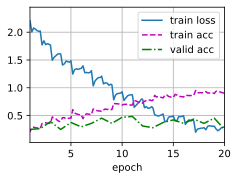

In [69]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

In [74]:
net, preds = get_net(), []
for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('./data/submission.csv', index=False)